# Предобработка данных (Data preprocessing) - создание хороших тренировочных наборов

# FeatureSelector - отбор признаков

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-colorblind')

In [4]:
data = pd.read_csv('data/sao-paulo-properties-april-2019.csv')
data.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


In [5]:
list(data.columns)

['Price',
 'Condo',
 'Size',
 'Rooms',
 'Toilets',
 'Suites',
 'Parking',
 'Elevator',
 'Furnished',
 'Swimming Pool',
 'New',
 'District',
 'Negotiation Type',
 'Property Type',
 'Latitude',
 'Longitude']

### Пропуски

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

Из этой информации мы уже можем видеть, что в наборе данных нет пустых значений, они заполнены нулями.

## Распределение предсказываемой величины

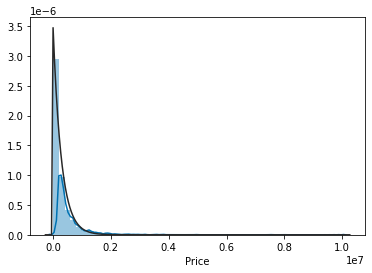

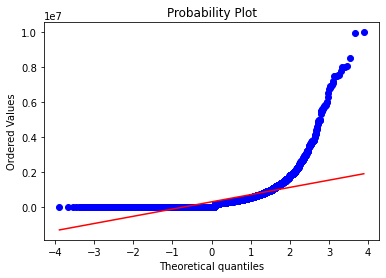

In [7]:
from scipy import stats
from scipy.stats import expon, norm

sns.distplot(data['Price'], fit=expon);
fig = plt.figure()
res = stats.probplot(data['Price'], plot=plt)

Видно, что цены имеют экпоненциальное распределение / скошенное влево номальное + большой пик при близких к нулю значениях. Попроюбуем привести это распределение к нормальному. В таких случаях часто помогает преобразование Бокса Кокса. Выглядит оно следующим образом: 

Для исходной последовательности $y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$ однопараметрическое преобразование Бокса-Кокса с параметром \lambda определяется следующим образом:

$ y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda-1}{\lambda},&\text{if } \lambda \neq 0,\\ \log{(y_i)},& \text{if } \lambda = 0.\end{cases}$

Параметр $\lambda$ можно выбирать, максимизируя логарифм правдоподобия. Еще один способ поиска оптимального значения параметра основан на поиске максимальной величины коэффициента корреляции между квантилями функции нормального распределения и отсортированной преобразованной последовательностью.

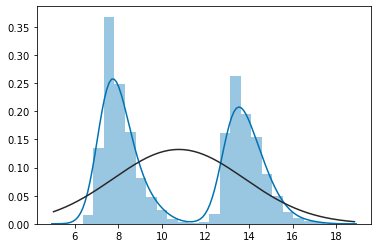

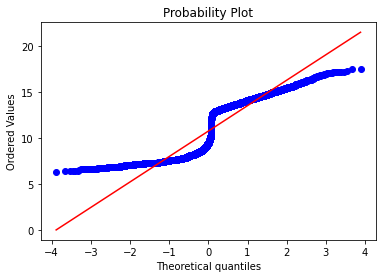

In [8]:
from scipy.stats import boxcox

binormal_price = boxcox(data['Price'], 0.01)
sns.distplot(binormal_price, fit=norm);
fig = plt.figure()
res = stats.probplot(binormal_price, plot=plt)

На рисунке видно, что получилось мультимодальное распределение с двумя пиками. Можно считать, что это два нормальных распределения. Можно так же сделать из биномального нормальное, но тогда занчение потеряет знак и при предсказание нельзя будет востановить исходную величину

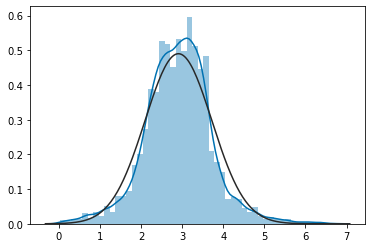

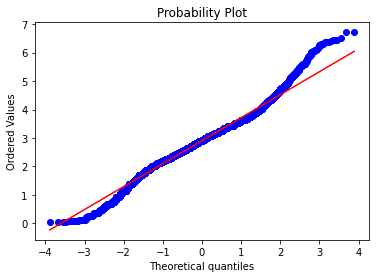

In [9]:
from scipy.stats import boxcox

normal_price = np.abs(binormal_price - binormal_price.mean())
sns.distplot(normal_price, fit=norm);
fig = plt.figure()
res = stats.probplot(normal_price, plot=plt)

Посмотрим на распределение всех остальных признаков. Для этого выбираются только числовые данные.

In [10]:
list(set(data.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

In [11]:
data_num = data.select_dtypes(include = ['float64', 'int64'])
data_num.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,-23.525025,-46.482436


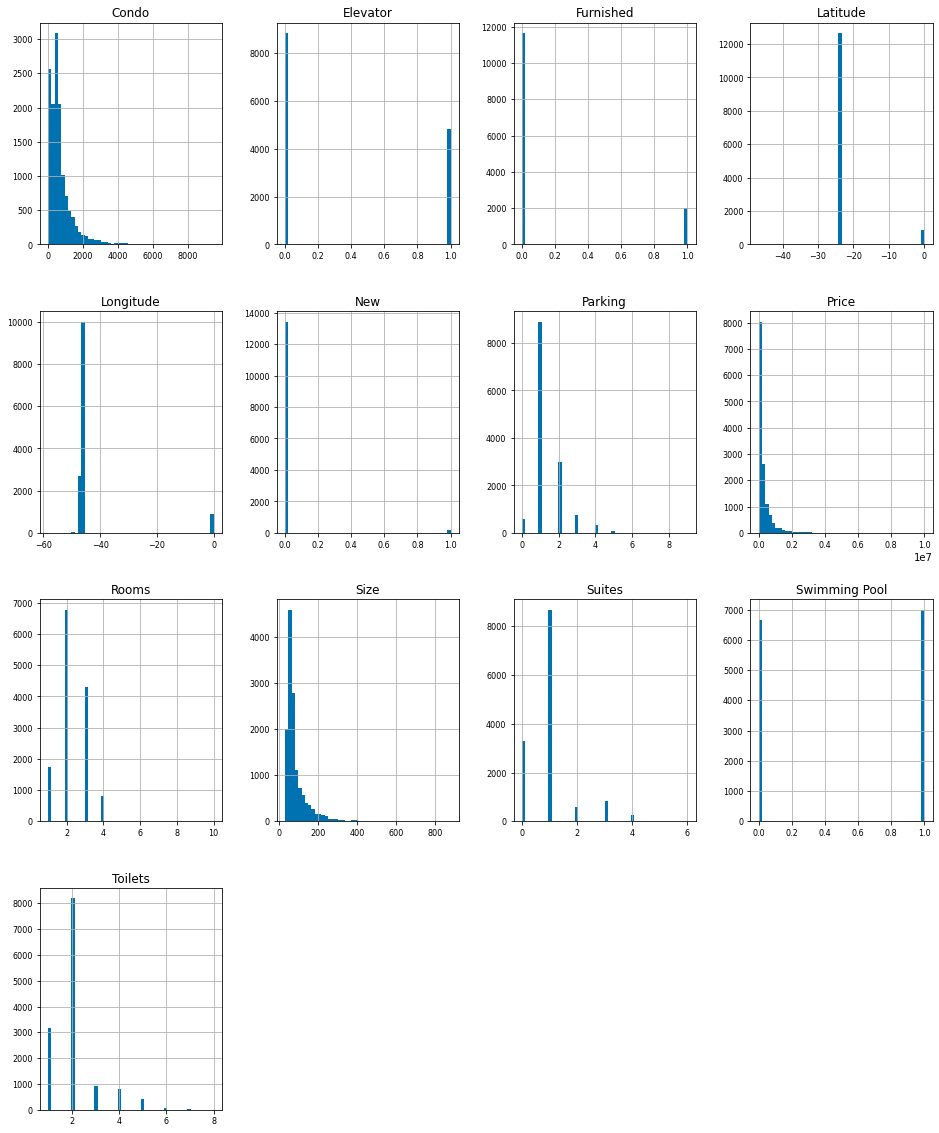

In [12]:
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Такие признаки, как 'Condo', 'Size' графически похожи по распределению на переменную 'Price'

## Корреляция

**Коллинеарными** называются признаки, которые сильно коррелируют друг с другом. В машинном обучении это приводит к снижению производительности обобщения данных из-за высокой дисперсии и меньшей интерпретируемости модели.

Попытаемся найти признаки, скоррелированные с 'Price'

In [13]:
corr_data = data_num.corr()['Price'][:-1]
correlated_features_list = corr_data[abs(corr_data) > 0.2].sort_values(ascending=False)
print("There are {} strongly values with SalePrice:\n{}".format(len(correlated_features_list), 
                                                                          correlated_features_list))

There are 7 strongly values with SalePrice:
Price      1.000000
Size       0.378450
Toilets    0.341887
Parking    0.337959
Suites     0.313267
Rooms      0.272267
Condo      0.203857
Name: Price, dtype: float64


Теперь у нас есть список скоррелированных со стоимостью жилья переменных (видно, что даже самые скоррелированные признаки имеют не сильную связь), но этот список неполон, поскольку мы знаем, что корреляция зависит от выбросов. Так что я могу действовать следующим образом:

1. Построить график числовых характеристик и посмотреть, какие из них имеют очень мало выбросов или же объяснимые выбросы.
2. Удалить выбросы и пересчитать корреляцию.

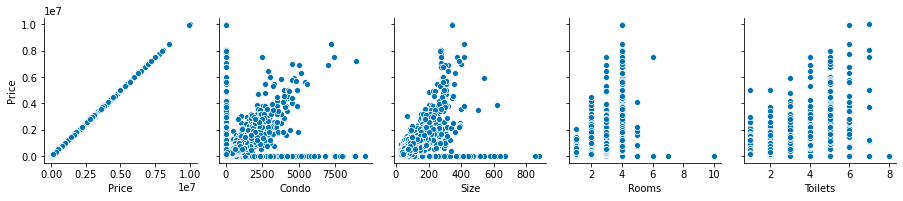

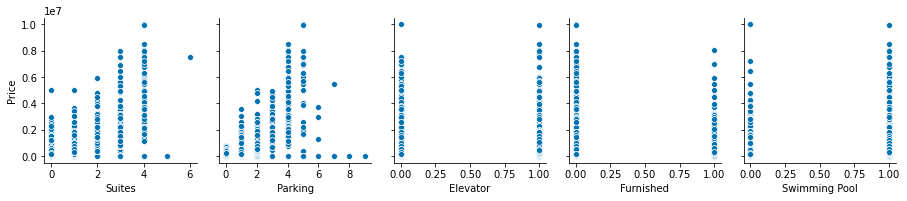

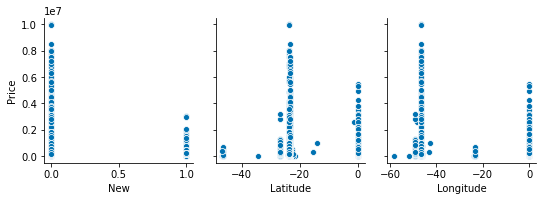

In [14]:
for i in range(0, len(data_num.columns), 5):
    sns.pairplot(data=data_num,
                 x_vars=data_num.columns[i:i+5],
                 y_vars=['Price'])

Видно, что большинство признаков можно рассматривать как категориальные (они расположены на прямых x=const), а признак Condo и Size как непрерывные величины. Их корреляция сильна сбита из-за интересных точек, которые находяться на линиях y = 0 и x = 0, но это не выбросы. Попробуем убрать эти линии из Condo и Size и пересчитаем их корреляции.

In [15]:
cont_data = data[['Size', 'Condo', 'Price']]
cont_data[cont_data['Price'] < 5] = np.NaN
cont_data[cont_data[['Size', 'Condo']] < 5] = np.NaN
cont_data.dropna(axis=0, inplace=True)

cont_data.shape

(11635, 3)

In [16]:
corr_data = cont_data.corr()['Price'][:-1]
correlated_features_list = corr_data[abs(corr_data) > 0.3].sort_values(ascending=False)
print("There are {} correlated values with Price:\n{}".format(len(correlated_features_list), 
                                                                          correlated_features_list))

There are 2 correlated values with Price:
Size     0.334302
Condo    0.314130
Name: Price, dtype: float64


Можно заметить, что корреляция Conda подросла до уровня Size, но все равно связь не очень сильная.

## Корреляция между признаками

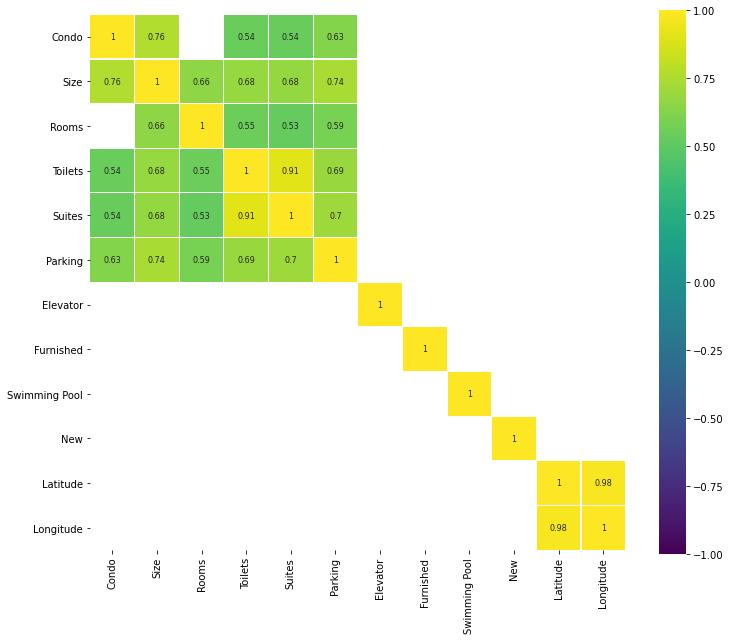

In [17]:
corr = data_num.drop('Price', axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Многие признаки коррелируют между собой.

Например кол-во туалетов в квартире коррелирует с размером, что в общем логично. Или размер квартиры с кол-вом мест в паркинге.


Таким образом, для сильно скоррелированных признаков (Size/Parking, Latitude/Longtitude) в модель имеет смысл включать лишь один из пары.

## Категориальные признаки

In [18]:
df_categ = data.select_dtypes(include=['int64', 'O']).drop(['Condo', 'Size'], axis=1)
df_categ.head()

,Price,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type
0,930,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment
1,1000,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment
2,1000,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment
3,1000,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment
4,1300,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment


Отобразим некоторые из признаков

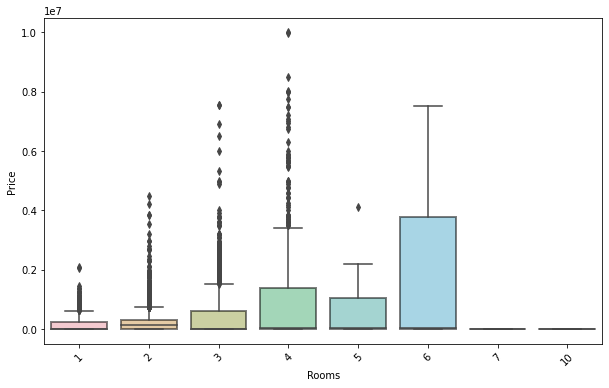

In [19]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Rooms', y='Price', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45);

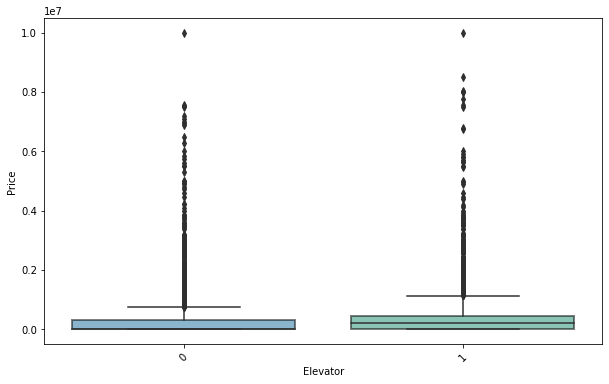

In [20]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Elevator', y='Price', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45);

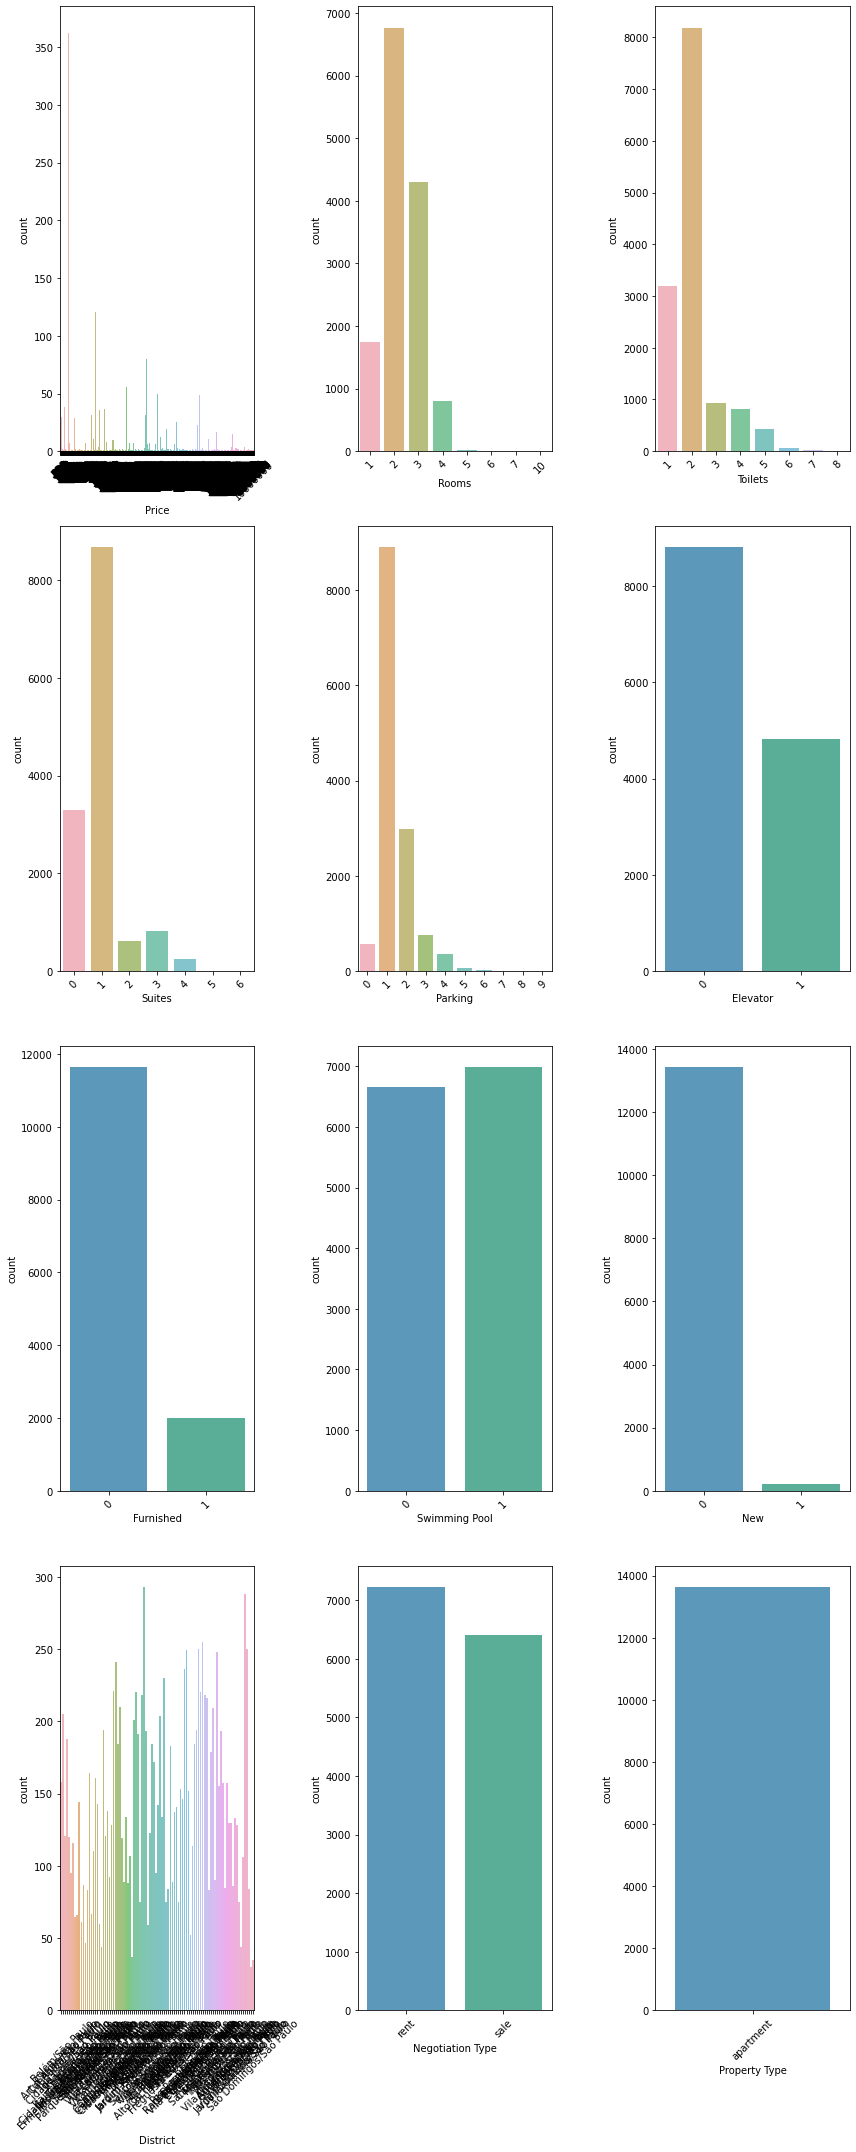

In [21]:
fig, axes = plt.subplots(round(len(df_categ.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_categ.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_categ.columns[i], alpha=0.7, data=df_categ, ax=ax) 

fig.tight_layout()

Признак New содержит слишком мало значений 1, поэтому его можно выкинуть. Этот признак не несет в себе информации для дальнейшего моделирования.

## Работа с категориальными признаками

1. Заменить значения
2. Encoding labels
3. One-Hot encoding
4. Binary encoding
5. Backward difference encoding
6. Miscellaneous features

![image.png](https://i.ytimg.com/vi/bJHN86aaDnY/maxresdefault.jpg)

In [22]:
data_dum = pd.get_dummies(data.dropna())
data_dum.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo,Negotiation Type_rent,Negotiation Type_sale,Property Type_apartment
0,930,220,47,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,1000,148,45,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,1000,100,48,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1000,200,48,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1300,410,55,2,2,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1


## Выбор переменных

1. Таким образом в датасете не было NaN значений, они было заполнены 0.
2. Исходя из корреляции между переменными нужно выкинуть такие признаки как Parking, Longtitude.
3. После анализа категориальных признаков, мы убрали признак New.
4. Итоговый набор: 
'Condo'
'Size'
'Rooms'
'Toilets'
'Suites'
'Parking'
'Elevator'
'Furnished'
'Swimming Pool'
'District'
'Negotiation Type'
'Property Type'
'Latitude'

# Выбросы (Outliers)

![image.png](https://cf.ppt-online.org/files1/slide/g/gRLiNju0JU39DsfXM8Ppa5lHFbByQ2d7xoekYtrWTv/slide-42.jpg)

Выброс - это любая точка данных, которая сильно отличается от остальных наблюдений в наборе.

Примеры:
- Когда успеваемость одного студента в среднем составляет более 90%, в то время как остальная часть группы находится на уровне 70% - явный выброс;
- Анализируя покупательские паттерны определенного клиента, выясняется, что внезапно появляется покупка с очень высокой стоимостью (например, 100 000). В то время как большинство транзакций данного клиента колеблется около 10 000. Независимо от причины покупка в 100 000 - это выброс среди общих данных;
- Usain Bolt - рекордные спринты определенно являются выбросами, когда рассматриваются большинство атлетов.

Существует множество причин существования выбросов. Возможно, аналитик допустил ошибку при вводе данных, или оборудование выдало ошибку измерения, или же выброс может быть даже преднамеренным. 

В случае наличия выбросов распределение данных будет иметь "тяжелые" хвосты (heavy tails).

Просто удалять выбросы - не всегда хорошая идея. Выбросы могут быть вполне обоснованными наблюдениями, а иногда и самыми интересными.  Важно изучить природу выброса, прежде чем принимать решение.

1. Если очевидно, что выброс вызван неверно введенными или измеренными данными, его следует удалить.
2. Если выброс не изменяет результаты, но влияет на предположения, можно удалить выброс.  Однако стоит отметить данный момент в отчете. Также можно построить модель с и без учета данного выброса и посмотреть на полученные результаты.

## Как найти выбросы?

1. Визуально

2. Математически

## Статистическая фильтрация

In [25]:
from sklearn.datasets import load_iris, load_diabetes

In [26]:
data = load_diabetes()
x = data.data
y = data.target
columns = data.feature_names

df = pd.DataFrame(x)
df.columns = columns
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### Box-plot

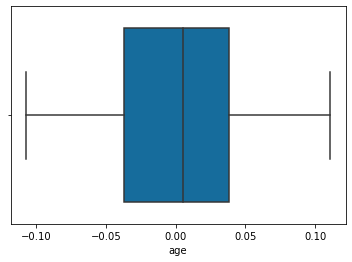

In [27]:
import seaborn as sns
sns.boxplot(x=df['age']);

Анатомия box-plots
![image.png](https://static.tildacdn.com/tild6130-3939-4833-b030-303762613530/image.png)

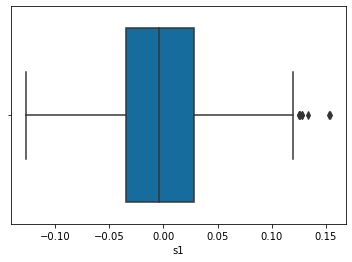

In [28]:
sns.boxplot(x=df['s1']);

Последний график показывает три точки-выброса между 0.1 и 0.15, не включенные в box с остальными наблюдениями, т.е. между квартилями.

### Scatter-plot

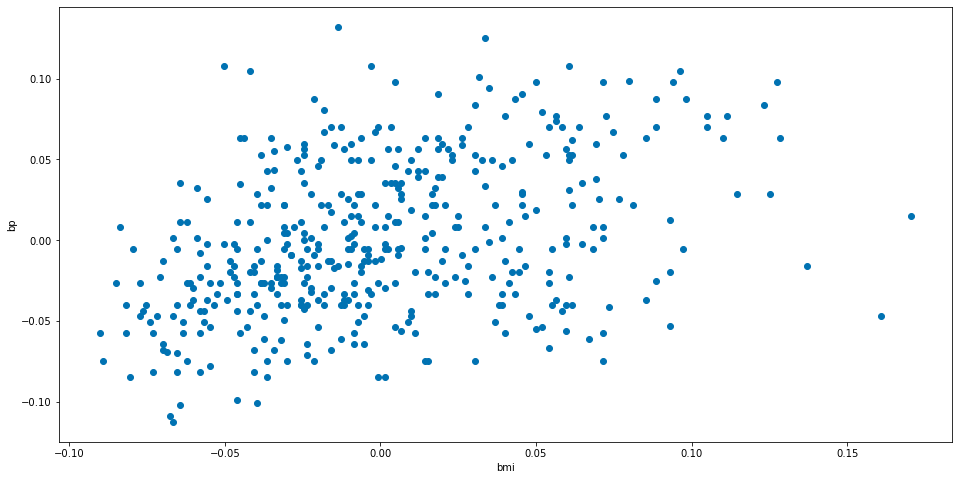

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(df['bmi'], df['bp'])
ax.set_xlabel('bmi')
ax.set_ylabel('bp')
plt.show();

Не явно, но видны точки за пределами "облака".

### Z-Score

Z-Score - это знаковое число стандартных отклонений, при котором значение точки наблюдения или данных превышает среднее значение наблюдаемого или измеряемого значения. [Z-core](https://en.wikipedia.org/wiki/Standard_score)

In [30]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df))
print(z)

[[0.80050009 1.06548848 1.29708846 ... 0.05449919 0.41855058 0.37098854]
 [0.03956713 0.93853666 1.08218016 ... 0.83030083 1.43655059 1.93847913]
 [1.79330681 1.06548848 0.93453324 ... 0.05449919 0.06020733 0.54515416]
 ...
 [0.87686984 1.06548848 0.33441002 ... 0.23293356 0.98558469 0.32567395]
 [0.9560041  0.93853666 0.82123474 ... 0.55838411 0.93615545 0.54515416]
 [0.9560041  0.93853666 1.53537419 ... 0.83030083 0.08871747 0.06442552]]


In [31]:
threshold = 3
print(np.where(z > 3))

(array([ 58, 123, 123, 123, 216, 230, 230, 256, 260, 261, 269, 322, 336,
       367, 441], dtype=int64), array([6, 4, 5, 7, 7, 4, 5, 2, 6, 6, 6, 7, 7, 2, 6], dtype=int64))


In [32]:
print(z[58][6])

3.8090716128062962


Например, 58-е наблюдение является выбросом.

### IQR score

The interquartile range (IQR), межквартильный интервал, также называемый средним или средним 50%, или технически H-спредом, является мерой статистической дисперсии, равной разнице между 75-м и 25-м процентилями, или между верхним и нижним квартилями, IQR = Q3 − Q1. [IQR](https://en.wikipedia.org/wiki/Interquartile_range)

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/800px-Boxplot_vs_PDF.svg.png)

In [33]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age    0.075375
sex    0.095322
bmi    0.065477
bp     0.072300
s1     0.062606
s2     0.060203
s3     0.064429
s4     0.073802
s5     0.065682
s6     0.061096
dtype: float64


Поскольку теперь у нас есть оценки IQR, выберем выбросы. Приведенный ниже код выдаст результат с истинными и ложными значениями. Точка данных с False означает, что эти значения действительны, тогда как True указывает на наличие выброса.

In [34]:
iris_iqr = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
iris_iqr.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [35]:
iris_iqr[iris_iqr.sum(axis=1) == 1].index

Int64Index([ 35,  58,  84, 117, 141, 168, 169, 202, 216, 245, 256, 260, 261,
            269, 276, 286, 336, 350, 353, 366, 367, 376, 406, 428, 441],
           dtype='int64')

Строчки с номерами 35,  58,  84, 117, 141, 168, 169, 202, 216, 245, 256, 260, 261,
            269, 276, 286, 336, 350, 353, 366, 367, 376, 406, 428, 441 являются выбросами